In [193]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

In [194]:
def logistic_function(x):
  y = 1/(1+np.exp(-x))
  return y

In [195]:

def test_logistic_function():
  """
  Test cases for the logistic_function.
  """
  # Test with scalar input
  x_scalar = 0
  expected_output_scalar = round(1 / (1 + np.exp(0)), 3) # Expected output: 0.5
  assert round(logistic_function(x_scalar), 3) == expected_output_scalar, "Test failed for scalar input"
  # Test with positive scalar input
  x_pos = 2
  expected_output_pos = round(1 / (1 + np.exp(-2)), 3) # Expected output: ~0.881
  assert round(logistic_function(x_pos), 3) == expected_output_pos, "Test failed for positive scalar input"
  # Test with negative scalar input
  x_neg = -3
  expected_output_neg = round(1 / (1 + np.exp(3)), 3) # Expected output: ~0.047
  assert round(logistic_function(x_neg), 3) == expected_output_neg, "Test failed for negative scalar input"

  # Test with numpy array input
  x_array = np.array([0, 2, -3])
  expected_output_array = np.array([0.5, 0.881, 0.047]) # Adjusted expected values rounded to 3 decimals
  # Use np.round to round the array element-wise and compare
  assert np.all(np.round(logistic_function(x_array), 3) == expected_output_array), "Test failed for numpy array input"
  print("All tests passed!")
# Run the test case
test_logistic_function()

All tests passed!


In [196]:
def log_loss(y_true, y_pred):
  # Ensure y_pred is clipped to avoid log(0)
  y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
  loss = -(y_true*np.log(y_pred)+(1-y_true)*np.log(1-y_pred))
  return loss

In [197]:
# Test function:
y_true, y_pred = 0, 0.1
print(f'log loss({y_true}, {y_pred}) ==> {log_loss(y_true, y_pred)}')
print("+++++++++++++--------------------------++++++++++++++++++++++++")
y_true, y_pred = 1, 0.9
print(f'log loss({y_true}, {y_pred}) ==> {log_loss(y_true, y_pred)}')

log loss(0, 0.1) ==> 0.10536051565782628
+++++++++++++--------------------------++++++++++++++++++++++++
log loss(1, 0.9) ==> 0.10536051565782628


In [198]:
def cost_function(y_true, y_pred):
  assert len(y_true) == len(y_pred), "Length of true values and length of predicted values do not match"
  n = len(y_true)
  loss_vec = -(y_true*np.log(y_pred)+(1-y_true)*np.log(1-y_pred))
  cost = (1/n)*np.sum(loss_vec)
  return cost

In [199]:

def test_cost_function():
  # Test case 1: Simple example with known expected cost
  y_true = np.array([1, 0, 1])
  y_pred = np.array([0.9, 0.1, 0.8])
  # Expected output: Manually calculate cost for these values
  # log_loss(y_true, y_pred) for each example
  expected_cost = (-(1 * np.log(0.9)) - (1 - 1) * np.log(1 - 0.9) +
  -(0 * np.log(0.1)) - (1 - 0) * np.log(1 - 0.1) +
  -(1 * np.log(0.8)) - (1 - 1) * np.log(1 - 0.8)) / 3

  # Call the cost_function to get the result
  result = cost_function(y_true, y_pred)
  # Assert that the result is close to the expected cost with a tolerance of 1e-6
  assert np.isclose(result, expected_cost, atol=1e-6), f"Test failed: {result} != {expected_cost}"
  print("Test passed for simple case!")
# Run the test case
test_cost_function()

Test passed for simple case!


In [200]:
# Function to compute cost function in terms of model parameters - using vectorization
def costfunction_logreg(X, y, w, b):

  n, d = X.shape
  assert len(y) == n, "Number of feature observations and number of target observations do not match."
  assert len(w) == d, "Number of features and number of weight parameters do not match."
  # Compute z using np.dot
  z = np.dot(X, w) + b # Matrix-vector multiplication and adding bias
  # Compute predictions using logistic function (sigmoid)
  y_pred = logistic_function(z)
  cost = cost_function(y, y_pred)
  return cost
# Testing the Function:
X, y, w, b = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1
print(f"cost for logistic regression(X = {X}, y = {y}, w = {w}, b = {b}) = {costfunction_logreg(X, y, w, b)}")

cost for logistic regression(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1) = 5.500008350784906


In [201]:
def compute_gradient(X, y, w, b):
  n, d = X.shape # X has shape (n, d)
  assert len(y) == n, f"Expected y to have {n} elements, but got {len(y)}"
  assert len(w) == d, f"Expected w to have {d} elements, but got {len(w)}"
  z = np.dot(X, w) + b
  y_pred = logistic_function(z)
  error = y_pred - y
  grad_w = (1 / n) * np.dot(X.T, error)
  grad_b = (1 / n) * np.sum(error)
  return grad_w, grad_b

In [202]:
# Simple test case
X = np.array([[10, 20], [-10, 10]]) # shape (2, 2)
y = np.array([1, 0]) # shape (2,)
w = np.array([0.5, 1.5]) # shape (2,)
b = 1 # scalar
# Assertion tests
try:
  grad_w, grad_b = compute_gradient(X, y, w, b)
  print("Gradients computed successfully.")
  print(f"grad_w: {grad_w}")
  print(f"grad_b: {grad_b}")
except AssertionError as e:
  print(f"Assertion error: {e}")

Gradients computed successfully.
grad_w: [-4.99991649  4.99991649]
grad_b: 0.4999916492890759


In [203]:
def gradient_descent(X, y, w, b, alpha, n_iter, show_cost=False, show_params=True):
  n, d = X.shape
  assert len(y) == n, "Number of observations in X and y do not match"
  assert len(w) == d, "Number of features in X and w do not match"
  cost_history = []
  params_history = []
  for i in range(n_iter):
    # Compute gradients
    grad_w, grad_b = compute_gradient(X, y, w, b)

    # Update weights and bias
    w -= alpha * grad_w
    b -= alpha * grad_b

    # Compute cost
    cost = costfunction_logreg(X, y, w, b)

    # Store cost and parameters
    cost_history.append(cost)
    params_history.append((w.copy(), b))

    # Optionally print cost and parameters
    # if show_cost and (i % 100 == 0 or i == n_iter - 1):
    #   print(f"Iteration {i}: Cost = {cost:.6f}")
    # if show_params and (i % 100 == 0 or i == n_iter - 1):
    #   print(f"Iteration {i}: w = {w}, b = {b:.6f}")
  return w, b, cost_history, params_history

# Test the gradient_descent function with sample data
X = np.array([[0.1, 0.2], [-0.1, 0.1]]) # Shape (2, 2)
y = np.array([1, 0]) # Shape (2,)
w = np.zeros(X.shape[1]) # Shape (2,) - same as number of features
b = 0.0 # Scalar
alpha = 0.1 # Learning rate
n_iter = 100000 # Number of iterations

# Perform gradient descent
w_out, b_out, cost_history, params_history = gradient_descent(X, y, w, b, alpha, n_iter, show_cost=True,
show_params=False)

# Print final parameters and cost
print("\nFinal parameters:")
print(f"w: {w_out}, b: {b_out}")
print(f"Final cost: {cost_history[-1]:.6f}")


Final parameters:
w: [38.51304248 18.83386869], b: -2.8176836626325836
Final cost: 0.008254


In [204]:
# Simple assertion test for gradient_descent
def test_gradient_descent():
  X = np.array([[0.1, 0.2], [-0.1, 0.1]]) # Shape (2, 2)
  y = np.array([1, 0]) # Shape (2,)
  w = np.zeros(X.shape[1]) # Shape (2,)
  b = 0.0 # Scalar
  alpha = 0.1 # Learning rate
  n_iter = 100000 # Number of iterations
  # Run gradient descent
  w_out, b_out, cost_history, _ = gradient_descent(X, y, w, b, alpha, n_iter, show_cost=False,
  show_params=False)
  # Assertions
  assert len(cost_history) == n_iter, "Cost history length does not match the number of iterations"
  assert w_out.shape == w.shape, "Shape of output weights does not match the initial weights"
  assert isinstance(b_out, float), "Bias output is not a float"
  assert cost_history[-1] < cost_history[0], "Cost did not decrease over iterations"
  print("All tests passed!")
# Run the test
test_gradient_descent()

All tests passed!


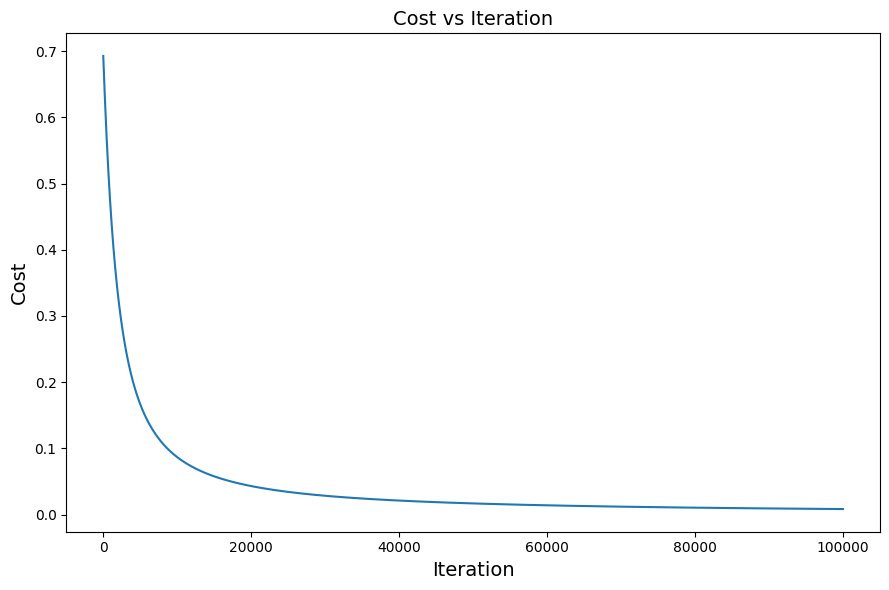

In [205]:
# Plotting cost over iteration
plt.figure(figsize = (9, 6))
plt.plot(cost_history)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Cost", fontsize = 14)
plt.title("Cost vs Iteration", fontsize = 14)
plt.tight_layout()
plt.show()

In [206]:
def prediction(X,w,b,threshold=0.5):
    y_test_prob=logistic_function(np.dot(X,w)+b)
    y_pred=(y_test_prob>=threshold).astype(int)
    return y_pred

In [207]:
def test_prediction():
  X_test = np.array([[0.5, 1.0], [1.5, -0.5], [-0.5, -1.0]]) # Shape (3, 2)
  w_test = np.array([1.0, -1.0]) # Shape (2,)
  b_test = 0.0 # Scalar bias
  threshold = 0.5 # Default threshold
  # Updated expected output
  expected_output = np.array([0, 1, 1])
  # Call the prediction function
  y_pred = prediction(X_test, w_test, b_test, threshold)
  # Assert that the output matches the expected output
  assert np.array_equal(y_pred, expected_output), f"Expected {expected_output}, but got {y_pred}"
  print("Test passed!")
  test_prediction()


In [208]:
def evaluate_classification(y_true,y_pred):
    TP=np.sum((y_true==1)&(y_pred==1))
    TN=np.sum((y_true==0)&(y_pred==0))
    FP=np.sum((y_true==0)&(y_pred==1))
    FN=np.sum((y_true==1)&(y_pred==0))
    confusion_matrix=np.array([[TN,FP],[FN,TP]])
    precision=TP/(TP+FP) if (TP+FP)>0.0 else 0.0
    recall=TP/(TP+FN) if (TP+FN)>0.0 else 0.0
    f1_score=(2*precision*recall)/(precision+recall) if (precision+recall)>0.0 else 0.0
    metrics={
        "confusion_matrix":confusion_matrix,
        "precision":precision,
        "recall":recall,
        "f1_score":f1_score
    }
    return metrics

Testing the model

In [209]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
           'DiabetesPedigreeFunction', 'Age', 'Outcome']

data_pima_diabetes = pd.read_csv(url, names=columns)

# Data cleaning
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data_pima_diabetes[columns_to_clean] = data_pima_diabetes[columns_to_clean].replace(0, np.nan)

# Fill missing values with median
data_pima_diabetes.fillna(data_pima_diabetes.median(), inplace=True)

# Inspect data
data_pima_diabetes.info()
data_pima_diabetes.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [210]:
# Train-test split
X = data_pima_diabetes.drop(columns=['Outcome']).values
y = data_pima_diabetes['Outcome'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training Logistic Regression Model:


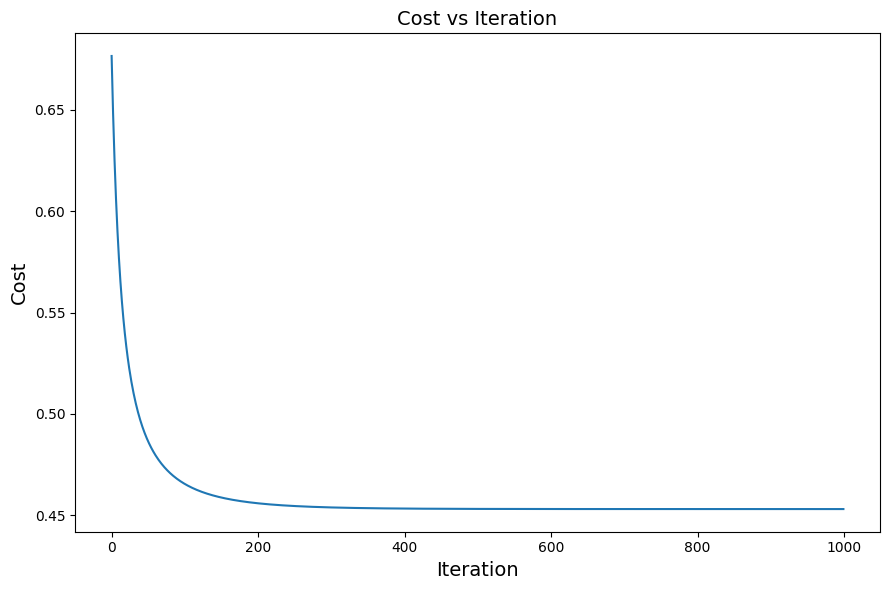

In [211]:

# Initialize parameters
w = np.zeros(X_train_scaled.shape[1])
b = 0.0
alpha = 0.1
n_iter = 1000
# Train model
print("\nTraining Logistic Regression Model:")
w, b, cost_history,params_history = gradient_descent(X_train_scaled, y_train, w, b, alpha, n_iter,
show_cost=True, show_params=False)
# Plot cost history
plt.figure(figsize=(9, 6))
plt.plot(cost_history)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Cost", fontsize=14)
plt.title("Cost vs Iteration", fontsize=14)
plt.tight_layout()
plt.show()

In [212]:
# Test model
y_train_pred = prediction(X_train_scaled, w, b)
y_test_pred = prediction(X_test_scaled, w, b)
# Evaluate train and test performance
train_cost = costfunction_logreg(X_train_scaled, y_train, w, b)
test_cost = costfunction_logreg(X_test_scaled, y_test, w, b)
print(f"\nTrain Loss (Cost): {train_cost:.4f}")
print(f"Test Loss (Cost): {test_cost:.4f}")



Train Loss (Cost): 0.4531
Test Loss (Cost): 0.5146


In [213]:
# Compute accuracy
test_accuracy = np.mean(y_test_pred == y_test) * 100
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# Compute evaluation metrics
metrics = evaluate_classification(y_test, y_test_pred)
conf_matrix = metrics["confusion_matrix"]
precision = metrics["precision"]
recall = metrics["recall"]
f1_score = metrics["f1_score"]

print(f"\nConfusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")


Test Accuracy: 70.78%

Confusion Matrix:
[[82 18]
 [27 27]]
Precision: 0.60
Recall: 0.50
F1-Score: 0.55


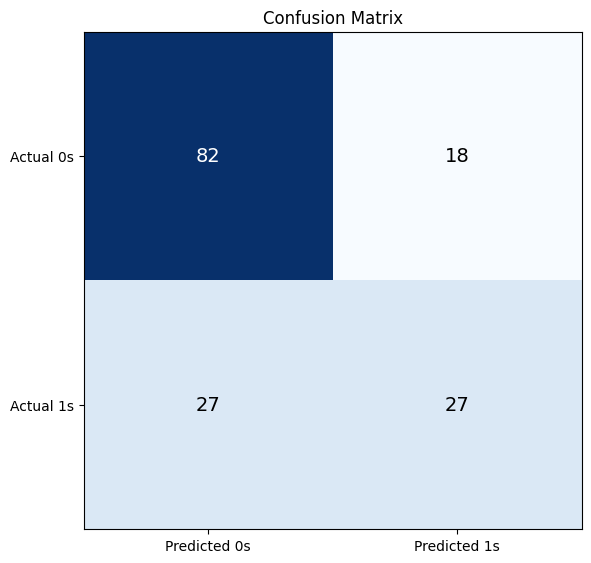

In [214]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(conf_matrix, cmap='Blues')

# Set ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Predicted 0s', 'Predicted 1s'])
ax.set_yticklabels(['Actual 0s', 'Actual 1s'])
ax.set_ylim(1.5, -0.5)  # Fix display upside-down issue

# Add text annotations with dynamic color based on cell value
for i in range(2):
    for j in range(2):
        color = 'white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black'
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color=color, fontsize=14)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
